In [107]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix

## read data 
CIP_data = pd.read_csv("CIP_data_encode_prev.csv")
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'CLINIC', 'YEAR', 'GENDERSP',
       'Susceptible', 'MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'REGION',
       'Midwest', 'Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION',
       'PREV_CLINIC'],
      dtype='object')


In [64]:
## FOR GRANT WE WANT ALL DATA 
all_data = pd.read_csv("GISP20002019.csv")
total_obs_all_data = all_data["TOTAL"].sum()
print(total_obs_all_data)
all_data.iloc[:, 5:len(all_data.columns)] = all_data.iloc[:, 5:len(all_data.columns)].apply(pd.to_numeric, errors='coerce')


112487


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_82501/37584077.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  all_data.iloc[:, 5:len(all_data.columns)] = all_data.iloc[:, 5:len(all_data.columns)].apply(pd.to_numeric, errors='coerce')


In [53]:
## To get summary stats, use original data 
CIP_data_full = pd.read_csv("CIP_Resistant_disagregated.csv")
print(CIP_data_full.columns)
total_obs = len(CIP_data_full)
print(total_obs)
#####
## initial stats for regional data 
#####
west = ['POR', 'PHX', 'HON', 'SDG', 'SFO', 'ANC', 'SEA', 'DEN', 'LVG', 'ORA', 'LBC', 'SLC', 'LAX']
southwest = ['OKC','MIN', 'ALB', 'DAL']
midwest = ['KCY','CHI', 'PON', 'CIN', 'JAC', 'IND', 'STL','DTR', 'MIL', 'COL', 'CLE']
southeast = ['GRB', 'NOR','WDC','MIA', 'BHM','FBG','ATL', 'RIC']
northeast = ['BUF','BOS', 'CAM', 'NYC', 'BAL', 'PHI']

CIP_data_full['REGION'] = CIP_data_full['CLINIC'].apply(lambda x: 
    'West' if (x in west) else (
        'Southwest' if (x in southwest) else(
            'Midwest' if (x in midwest) else(
                'Southeast' if (x in southeast) else(
                    'Northeast' if (x in northeast) else 'Other'))))) #drug_combinations = ['TetI']



regions = CIP_data_full['REGION'].unique()
regional_average = []
for region in regions:
    regional_data =len(CIP_data_full.loc[CIP_data_full['REGION'] == region])
    regional_average.append({region,(regional_data/total_obs)*100}) 
 
print(regional_average)
#####
## initial stats for gender data
#####

gendersps = CIP_data_full['GENDERSP'].unique()
gendersp_average = []
for gendersp in gendersps:
    gendersp_data =len(CIP_data_full.loc[CIP_data_full['GENDERSP'] == gendersp])
    gendersp_average.append({gendersp,(gendersp_data/total_obs)*100}) 
 
print(gendersp_average)


Index(['Unnamed: 0', 'CLINIC', 'YEAR', 'GENDERSP', 'Susceptible'], dtype='object')
112487
[{'Southwest', 12.560562553895116}, {'West', 35.42098198013993}, {17.462462328980237, 'Southeast'}, {'Northeast', 11.79602976343933}, {'Midwest', 22.75996337354539}]
[{'MSW', 70.61527109799354}, {22.368807062149404, 'MSM'}, {4.299163458888583, 'MSMW'}, {'Oth/Unk/Missing', 2.7167583809684674}]


In [68]:
### % resistant to CIP 
1 - sum(CIP_data_full["Susceptible"])/total_obs



####
all_resistance_to_CIPR = all_data[['CipR_PenR_TetR', 'CipR_PenI_TetI', 'CipR_TetR_PenI', 'CipR_PenI',
       'CipR_PenR_TetI', 'AziRS_CipR_PenR_TetR', 'CipR_PenR',
       'AziRS_CipR_TetR_PenI', 'CfxRS_CipR_PenR_TetR', 'AziRS_CipR_PenI_TetI',
       'CipR_TetI', 'CipR', 'CipR_TetR', 'CfxRS_CipR_TetR_PenI',
       'AziRS_CipR_PenR_TetI', 'CroRS_CfxRS_CipR_PenR_TetR']].sum(axis = 1) 

print(all_resistance_to_CIPR.sum()/total_obs)
print(all_resistance_to_CIPR.sum())

###14.45%?
### 0.14488785370753954

0.14488785370753954
16298.0


In [101]:
## permutation importance on test data 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha = 1.291549665014884, random_state=10, learning_rate = 'adaptive' )
#train data: 2000 - 2009
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_train = train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5, random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)
model_fit = model_nn.fit(X_train, y_train)

#test data: 2010 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_test = test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5, random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

y_predict = model_nn.predict(X_test)

ROC_AUC_neural_network_apparent = metrics.roc_auc_score(y_test, y_predict)



In [102]:
print(ROC_AUC_neural_network_apparent)
perm = PermutationImportance(model_fit, random_state=1).fit(X_test,y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

0.5975237289215681


Weight,Feature
0.0654 ± 0.0024,PREV_CLINIC
0.0381 ± 0.0033,PREV_REGION
0.0285 ± 0.0017,MSW
0.0218 ± 0.0034,West
0.0062 ± 0.0019,MSMW
0.0057 ± 0.0014,MSM
0.0051 ± 0.0016,Midwest
0.0006 ± 0.0004,Oth/Unk/Missing
0.0001 ± 0.0007,Northeast
-0.0014 ± 0.0008,Southwest


In [96]:
PI = permutation_importance(model_fit, X_test, y_test, n_repeats = 100, random_state = 42)
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']
for i in PI.importances_mean.argsort()[::-1]:
    if PI.importances_mean[i] - 2 * PI.importances_std[i] > -1:
            print(f"{feature_names[i]:<8}"
            f"{PI.importances_mean[i]:.3f}"
            f" +/- {PI.importances_std[i]:.3f}")

PREV_CLINIC0.075 +/- 0.001
West    0.022 +/- 0.001
Northeast0.009 +/- 0.001
MSW     0.008 +/- 0.001
Southwest0.007 +/- 0.001
Midwest 0.006 +/- 0.001
Southeast0.006 +/- 0.001
PREV_REGION0.002 +/- 0.001
MSMW    0.001 +/- 0.000
MSM     -0.000 +/- 0.001
Oth/Unk/Missing-0.001 +/- 0.000


In [112]:
## now do hyperparameter tuning again post PI
space = dict()
space['activation'] = ['tanh', 'relu']
space['alpha'] = np.logspace(-1, 1, 10)
space['learning_rate'] = ['constant','adaptive']
space['hidden_layer_sizes'] = [(4), (6),(8), (12), (13)]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha = 1.291549665014884, random_state=10, learning_rate = 'adaptive' )

X = CIP_data_no_drop[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y = CIP_data_no_drop['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X, y = oversample.fit_resample(X,y)
model_fit = model_nn.fit(X, y)

search = RandomizedSearchCV(model_nn, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

#Best Score: 0.8012056228019937
#Best Hyperparameters: {'learning_rate': 'constant', 'hidden_layer_sizes': 13, 'alpha': 1.291549665014884, 'activation': 'tanh'}

KeyboardInterrupt: 

In [109]:
## now get ROC_AUC based on threshold of 0.5 with dropped dataset
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
#train data: 2000 - 2010 
train_data = CIP_data.loc[CIP_data['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
print(train_data)
X_train = train_data[['MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC']]
y_train = train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)

#test data: 2011 - 2019 
test_data = CIP_data.loc[CIP_data['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC']]
y_test = test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)


#fit model on training data
model_fit = model_nn.fit(X_train, y_train)

#test data
y_predict = model_fit.predict(X_test)

ROC_AUC_nn = metrics.roc_auc_score(y_predict, y_test)


print('ROC_AUC_nn_apparent:', ROC_AUC_nn) 
#0.5677

        Unnamed: 0.1  Unnamed: 0 CLINIC  YEAR         GENDERSP  Susceptible  \
0                  0           0    ALB  2000              MSW            1   
1                  1           0    ALB  2000              MSW            1   
2                  2           0    ALB  2000              MSW            1   
3                  3           0    ALB  2000              MSW            1   
4                  4           0    ALB  2000              MSW            1   
...              ...         ...    ...   ...              ...          ...   
112401        112401        1963    STL  2004  Oth/Unk/Missing            1   
112402        112402        1963    STL  2004  Oth/Unk/Missing            1   
112403        112403        1963    STL  2004  Oth/Unk/Missing            1   
112404        112404        1963    STL  2004  Oth/Unk/Missing            1   
112405        112405        1963    STL  2004  Oth/Unk/Missing            1   

        MSMW  MSW  Oth/Unk/Missing     REGION  Nort

KeyError: "['MSM', 'Midwest'] not in index"

In [115]:
## now get ROC_AUC based on threshold of 0.5 with non-dropped dataset
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
#train data: 2000 - 2010 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_train = train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)

#test data: 2010 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([ 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_test = test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

#fit model on training data
model_fit = model_nn.fit(X_train, y_train)

#test data
y_predict = model_fit.predict(X_test)

ROC_AUC_nn = metrics.roc_auc_score(y_predict, y_test)


print('ROC_AUC_nn_apparent:', ROC_AUC_nn) 
#0.5884341867192842

ROC_AUC_nn_apparent: 0.5961956831243176


In [120]:
## permutation importance on test data WITH NEW parameters
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
#train data: 2000 - 2009
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_train = train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)
model_fit = model_nn.fit(X_train, y_train)

#test data: 2010 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_test = test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

y_predict = model_nn.predict(X_test)

ROC_AUC_neural_network_apparent = metrics.roc_auc_score(y_test, y_predict)

print('ROC_AUC_nn_apparent:', ROC_AUC_neural_network_apparent) 

print(ROC_AUC_neural_network_apparent)
perm = PermutationImportance(model_fit, random_state=1).fit(X_test,y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())


PI = permutation_importance(model_fit, X_test, y_test, n_repeats = 100, random_state = 42)
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']
for i in PI.importances_mean.argsort()[::-1]:
    if PI.importances_mean[i] - 2 * PI.importances_std[i] > -1:
            print(f"{feature_names[i]:<8}"
            f"{PI.importances_mean[i]:.3f}"
            f" +/- {PI.importances_std[i]:.3f}")
#0.6050601090340751

ROC_AUC_nn_apparent: 0.599349287519092
0.599349287519092
PREV_CLINIC0.048 +/- 0.001
MSW     0.010 +/- 0.001
PREV_REGION0.010 +/- 0.001
West    0.008 +/- 0.001
Northeast0.007 +/- 0.001
Southeast0.006 +/- 0.001
Southwest0.004 +/- 0.001
Midwest 0.003 +/- 0.001
MSMW    0.003 +/- 0.000
MSM     0.001 +/- 0.001
Oth/Unk/Missing0.000 +/- 0.000


In [130]:
### now look at response of sensitivity and specificity to classification threshold - non-dropped
### using split data - do not do bootstrapping
##model
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
#train data: 2000 - 2010 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_train = train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)


#test data: 2011 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_test = test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

#loop setup
threshold_seq = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
theshold_seq = np.linspace(0,1,101)
#only using split data - can't have optimisation-corrected metrics
#sensitivity_optimised = []
#specificity_optimised = [] #no bootstrapping, no 95% CI 

#want to keep the data the same between threshold runs
#   train 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_train = train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5)
X_train, y_train = oversample.fit_resample(X_train,y_train)

# test
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_test = test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5)
X_test, y_test = oversample.fit_resample(X_test,y_test)


#dataframes
sensitivity_test_threshold = []
specificity_test_threshold = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:
  print(threshold)
  #1. Create model using all data and get the apparent sensitivity and specificty 

  model_fit_train = model_nn.fit(X_train, y_train)


  #2. Test model on training data to get test specificity and sensitivity 
  
  y_predict = model_fit_train.predict(X_test)
  y_predict_proba = model_fit.predict_proba(X_test)
 
  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )
  
  # Save results
  sensitivity_test_threshold.append(sensitivity_test)
  specificity_test_threshold.append(specificity_test)


  


0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9


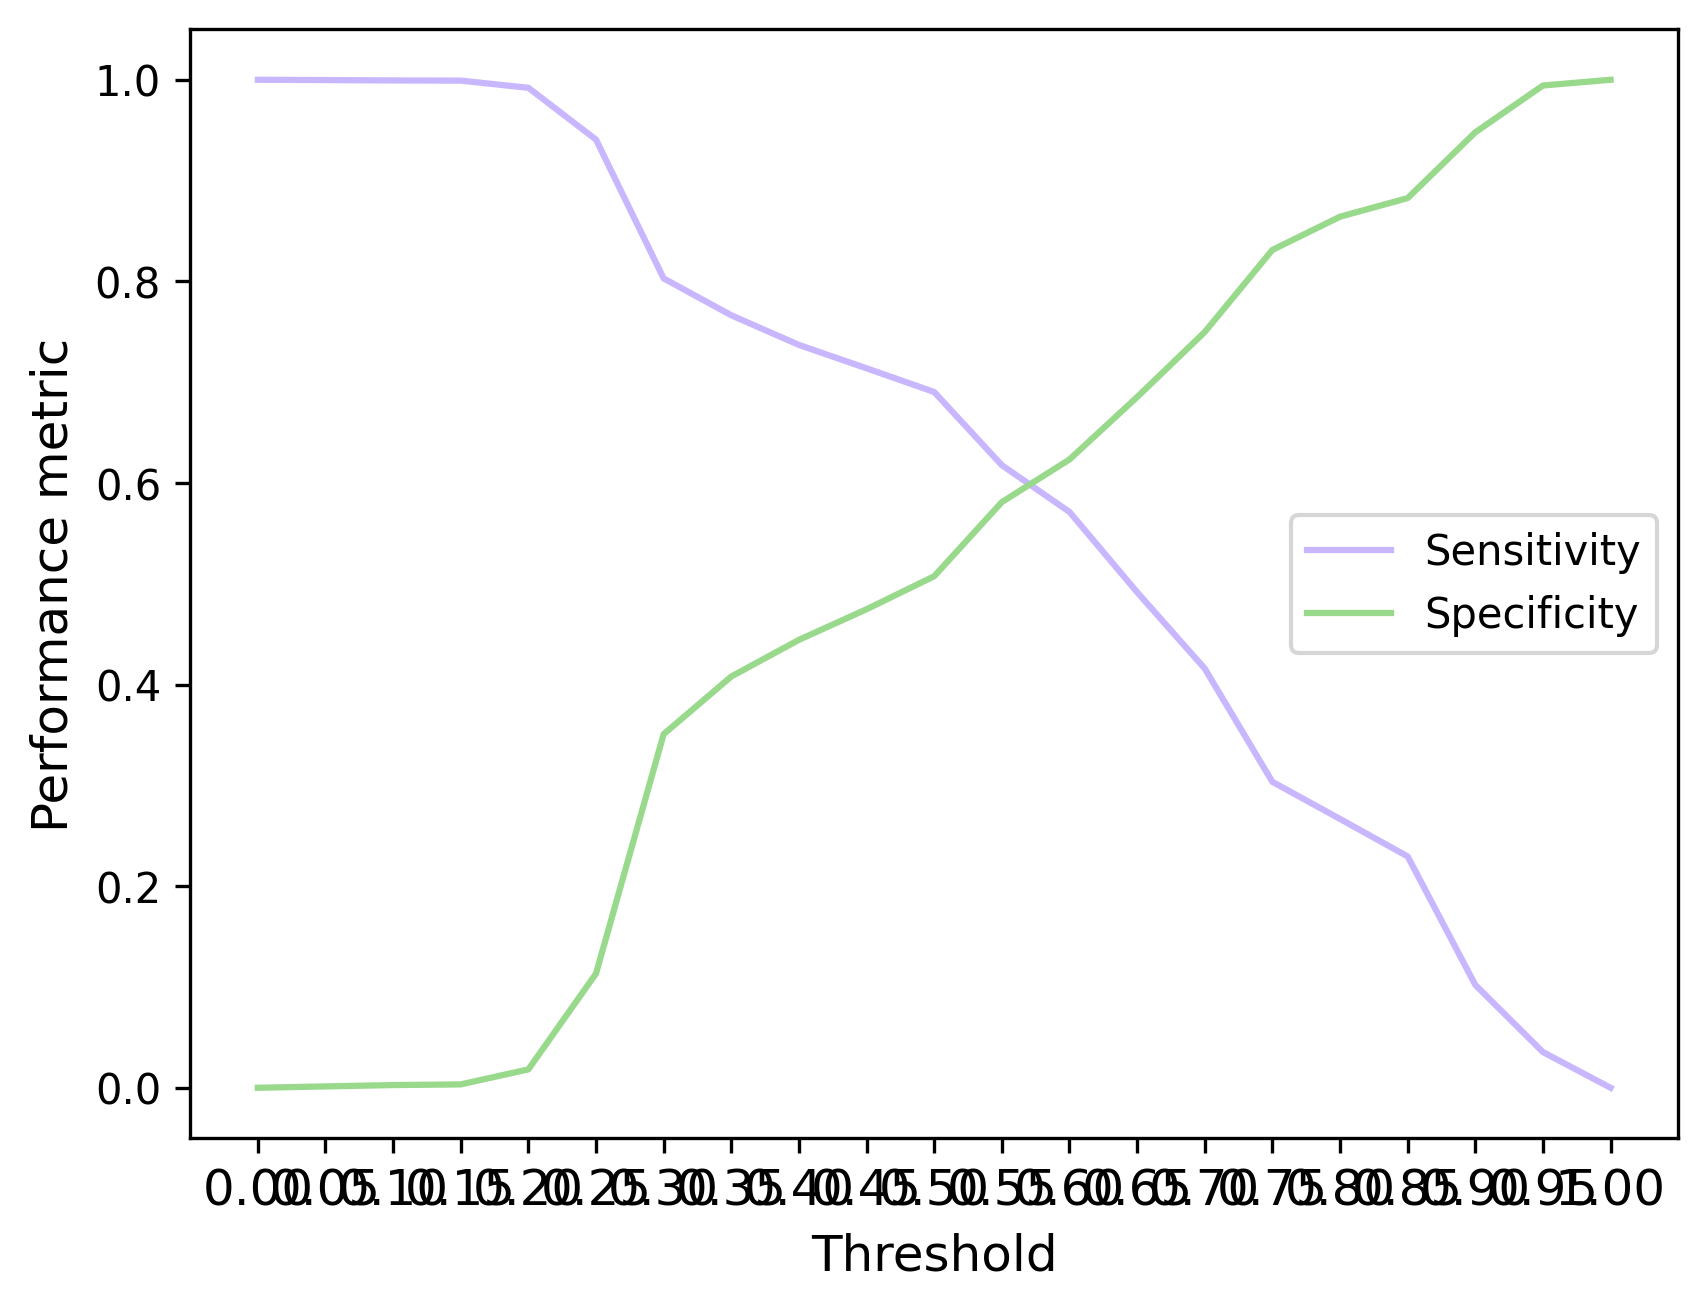

In [129]:
sensitivity_test_threshold = pd.DataFrame(sensitivity_test_threshold)
specificity_test_threshold = pd.DataFrame(specificity_test_threshold)

theshold_seq = np.linspace(0,1,21)
plt.plot(threshold_seq, sensitivity_test_threshold, color = "#c8b6ff", label = "Sensitivity")
plt.plot(threshold_seq, specificity_test_threshold, color = "#99d98c", label = "Specificity")
#plt.errorbar(threshold_seq, specificity_test_table, yerr = y_err_sensitivity, ecolor="lightblue")

plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Performance metric", fontsize=12)
plt.xticks(np.linspace(0,1,11), fontsize=12)
plt.rcParams['figure.dpi'] = 300
plt.legend()

In [128]:
### repeat for different samples ROC-AUC 

n_iterations = 1


ROC_dataframe_all = pd.DataFrame()

model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )

for i in range(n_iterations):
    #Generate new test and train data 
            # train
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
    X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
    y_train = train_data['Susceptible']

    oversample = RandomOverSampler(sampling_strategy = 0.5, random_state=42)
    X_train, y_train = oversample.fit_resample(X_train,y_train)

            # test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
    X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
    y_test = test_data['Susceptible']
    oversample = RandomOverSampler(sampling_strategy = 0.5, random_state=42)
    X_test, y_test = oversample.fit_resample(X_test,y_test)

    # Train model on training data - don't need to test on test data 
    model_fit_train = model_nn.fit(X_train, y_train)

    # Permutation importance 

    y_predict = model_nn.predict(X_test)

    ROC_AUC = metrics.roc_auc_score(y_test, y_predict)
    #Save results. 1 = +ve, -1 = -ve 
    ROC_dataframe_all.append(ROC_AUC)

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_82501/1759974246.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ROC_dataframe_all.append(ROC_AUC)


TypeError: cannot concatenate object of type '<class 'numpy.float64'>'; only Series and DataFrame objs are valid

In [ ]:
ROC_dataframe_all.append(ROC_AUC).mea()
